In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append("/home/miri/Documents/bachelorthesis/plots")
from plot_utils import *

2025-02-19 19:43:09.871393: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-02-19 19:43:09.879966: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-02-19 19:43:09.882539: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-19 19:43:10.333106: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
data_path = "../../data/adam_wobn"
image_path = "./images"
lr_to_p_fn = lambda js: np.sqrt(0.001/js["optimizer"]["lr"])
lr_to_log_fn = lambda js: np.log(js["optimizer"]["lr"])
wd_to_log_fn = lambda js: np.log(js["optimizer"]["lambda_wd"])
p_to_p_fn = lambda js: js["norm"]["norm_multiply"]
acc_fn = lambda p : max_acc(get_stats(p,"test_stats"))

Max test accuracy of Standard is 80.56% with lr 0.0004


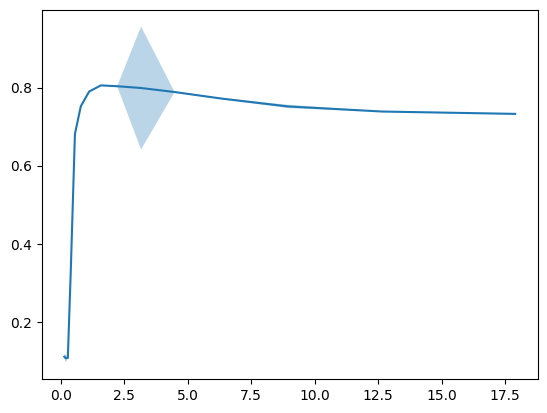

In [8]:
x,y,_ = plot_hyperparam_y(get_subexpspaths(f"{data_path}/noreg"),lr_to_p_fn, acc_fn,plt, norm=False,label="noreg")
print("Max test accuracy of Standard is {0}% with lr {1}".format(round(100*y.max(),2),round(0.001/(x[y.argmax()]**2),6)))


Max test accuracy of norm is 84.58% with p 1.3
Max test accuracy of center_norm is 83.95% with p 1.4
Max test accuracy of center_norm_uncenter is 84.05% with p 1.5
Max test accuracy of global_center_std_uncenter is 84.04% with p 0.9
Max test accuracy of wd is 81.34% with lambda 1.9999999999999998e-05


(<matplotlib.legend.Legend at 0x7888b75127b0>,
 <matplotlib.legend.Legend at 0x788909327560>)

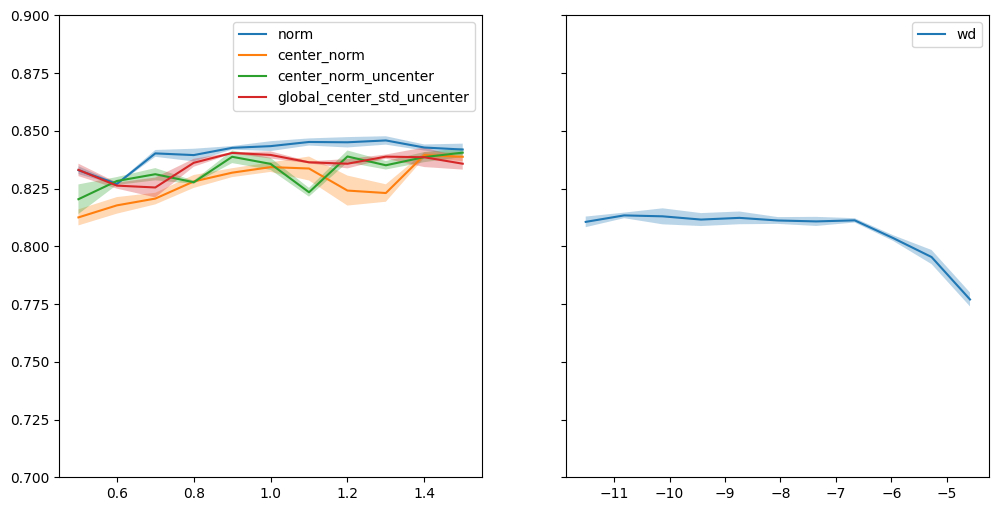

In [10]:
fig,axs = plt.subplots(ncols=2,nrows=1,sharey="row")

for exp in ["norm","center_norm","center_norm_uncenter","global_center_std_uncenter"]:
    x,y,_ = plot_hyperparam_y(get_subexpspaths(f"{data_path}/{exp}",skip=lambda s : s.endswith("0")),p_to_p_fn,acc_fn, axs[0], norm=False, label=exp)
    print("Max test accuracy of {0} is {1}% with p {2}".format(exp,round(100*y.max(),2),x[y.argmax()]))

x,y,_ = plot_hyperparam_y(get_subexpspaths(f"{data_path}/wd"),wd_to_log_fn,acc_fn,axs[1], norm=False,label="wd")
print("Max test accuracy of wd is {0}% with lambda {1}".format(round(100*y.max(),2),np.exp(x[y.argmax()])))


fig.set_size_inches(12,6)
axs[0].set_ylim(0.7,0.9)
axs[0].legend(),axs[1].legend()

In [10]:

import json
writer = write(name="a_wobn",path="../../run/adam_wobn",h=12,max_tasks=11)
for norm_fn in ["norm","center_norm_uncenter","center_norm","global_center_std_uncenter"]:
    for p in [0.5,0.6,0.7,0.8,0.9,1.0,1.1,1.2,1.3,1.4,1.5]:
        with open("../../data/adam_wobn/noreg/0.0004/settings.json", "r") as f:
            js = json.load(f)

        del js["save_path"]
        js["num_steps"] = 100000
        js["save_args"]["save_states_every"] = 100000
        js["save_args"]["save_grad_every"] = -1
        js["at_step"] = 0
        js["norm"]["norm_every"] = 1
        js["norm"]["norm_multiply"] = p
        js["norm"]["norm_fn"] = norm_fn
        js["norm"]["apply_norm_to"] = "conv&kernel|out&kernel"

        os.makedirs(f"../../data/adam_wobn/{norm_fn}/{p}_1",exist_ok=True)
        with open(f"../../data/adam_wobn/{norm_fn}/{p}_1/settings.json","w") as f:
            json.dump(js,f)

        writer.write(f"python code/main.py ./data/adam_wobn/{norm_fn}/{p}_1/ --reset \n")

start_wd = 0.00001
for i in range(11):
    with open("../../data/adam_wobn/noreg/0.0004/settings.json", "r") as f:
        js = json.load(f)

    wd = start_wd*(2**i)
    js["optimizer"]["lambda_wd"] = wd
    js["optimizer"]["apply_wd_to"] = "conv&kernel|out&kernel"

    os.makedirs(f"../../data/adam_wobn/wd/{str(round(wd,8))}",exist_ok=True)
    with open(f"../../data/adam_wobn/wd/{str(round(wd,8))}/settings.json","w") as f:
        json.dump(js,f)

    writer.write(f"python code/main.py ./data/adam_wobn/wd/{str(round(wd,8))}/ --reset \n")


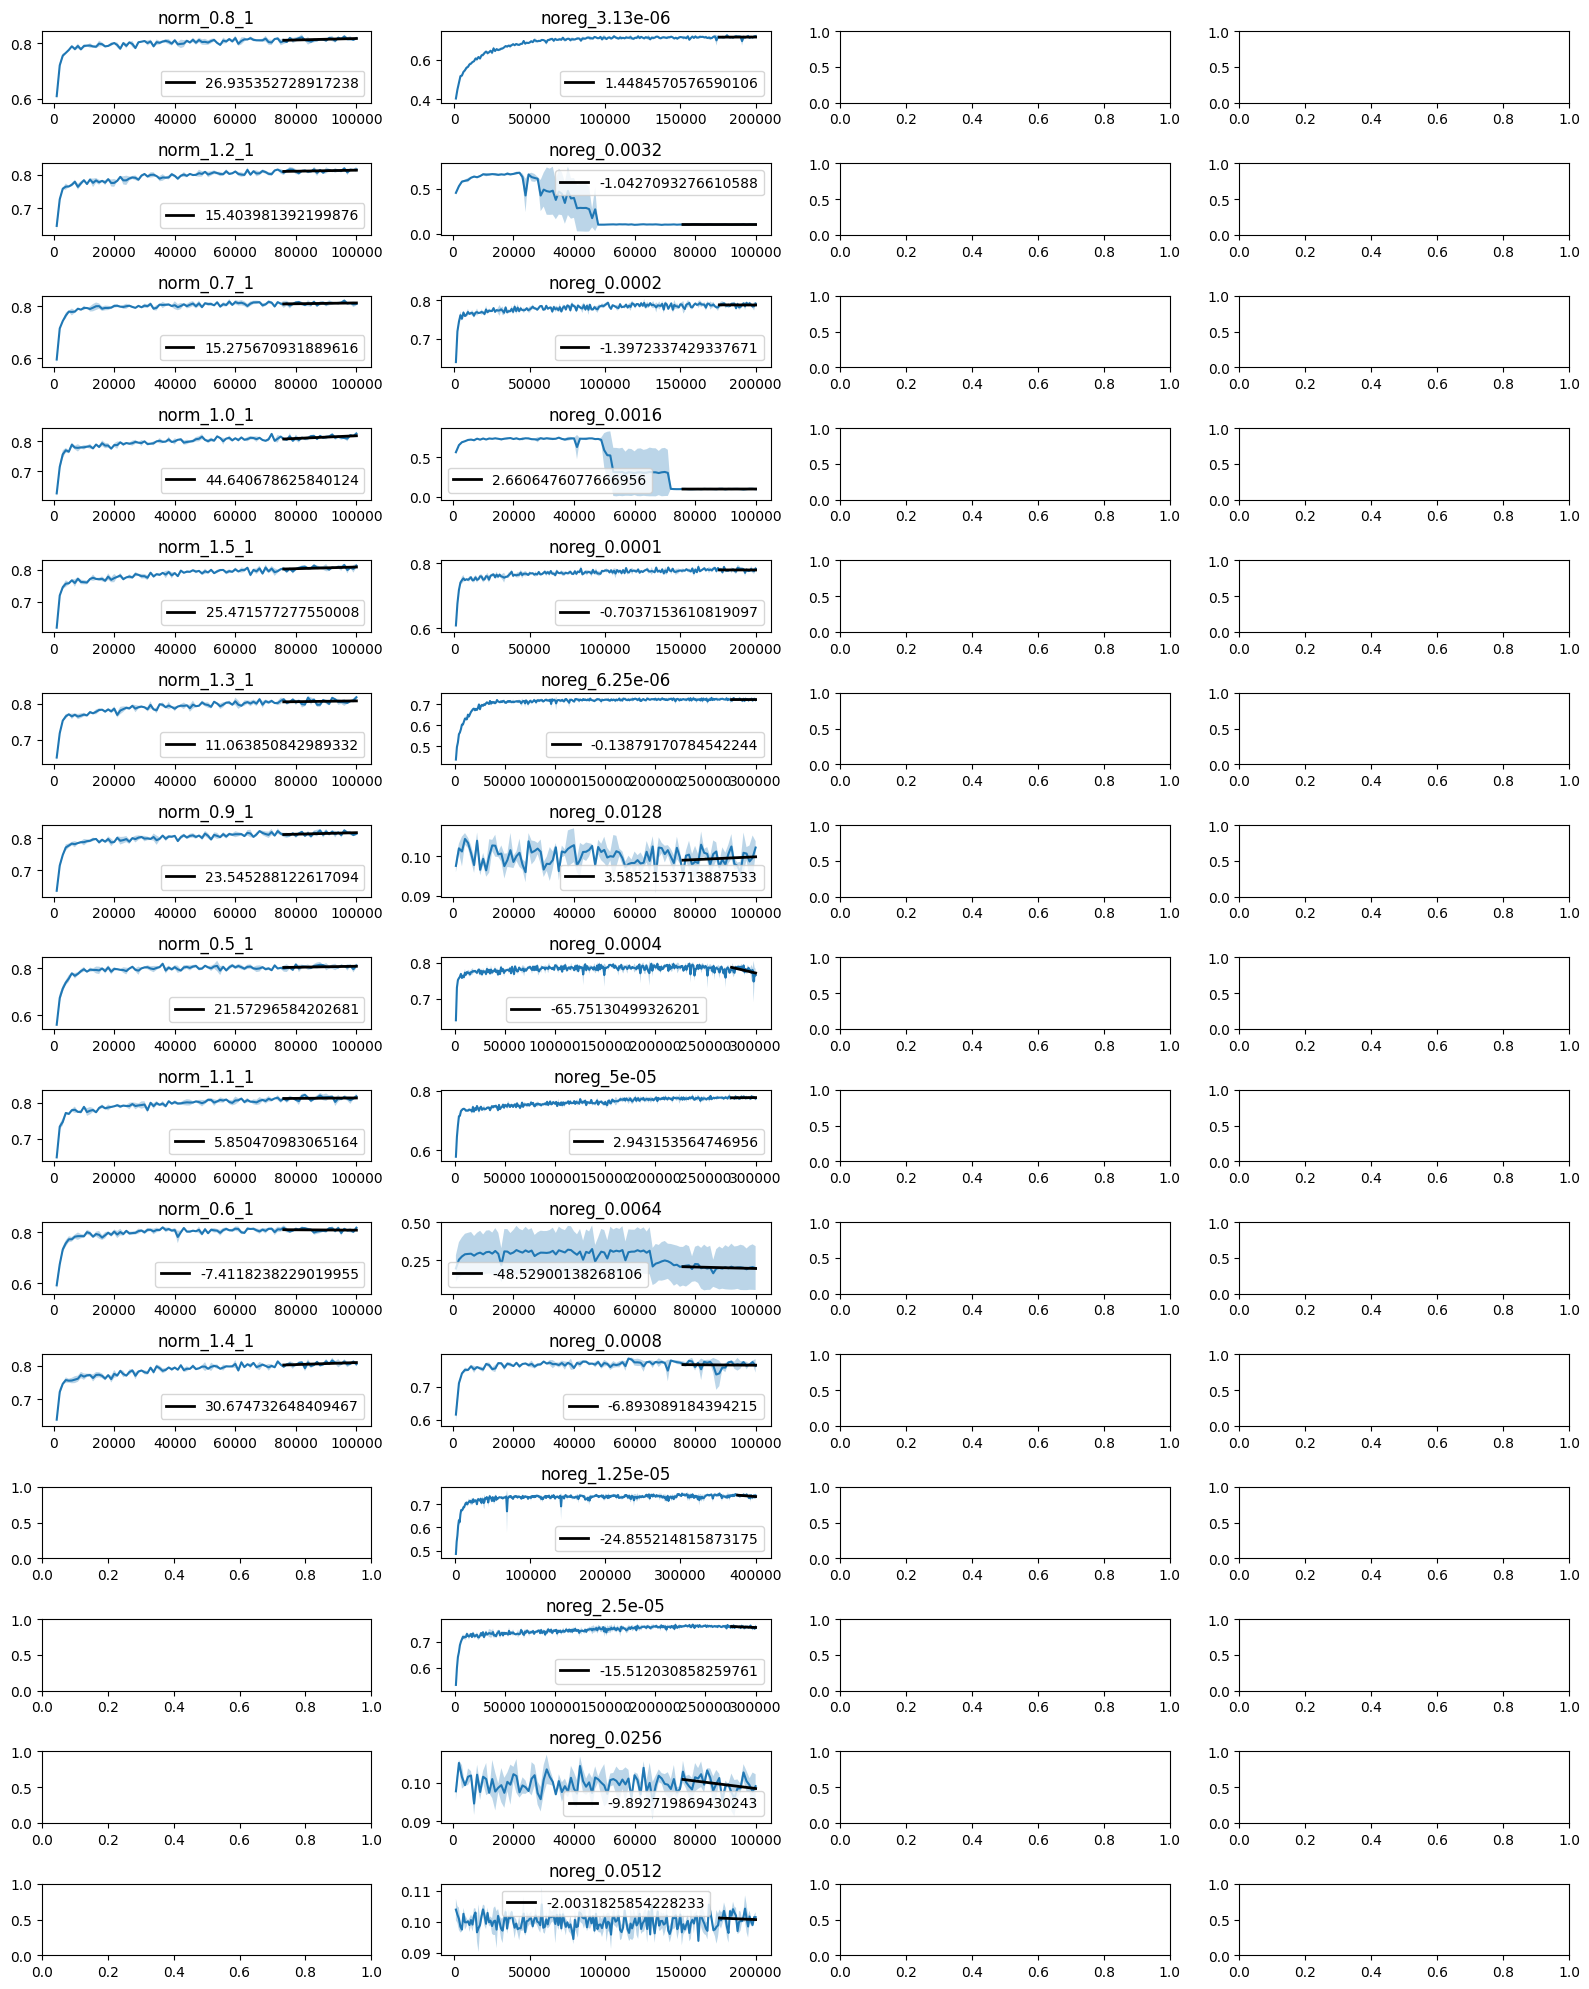

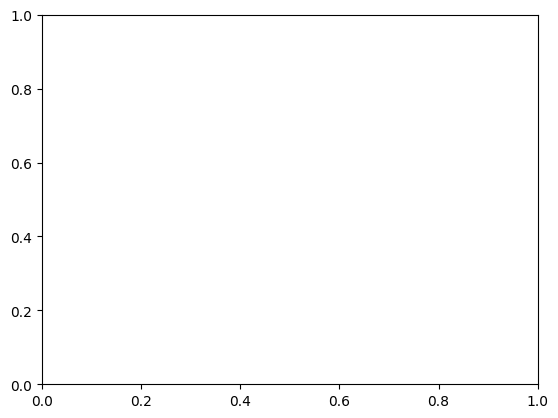

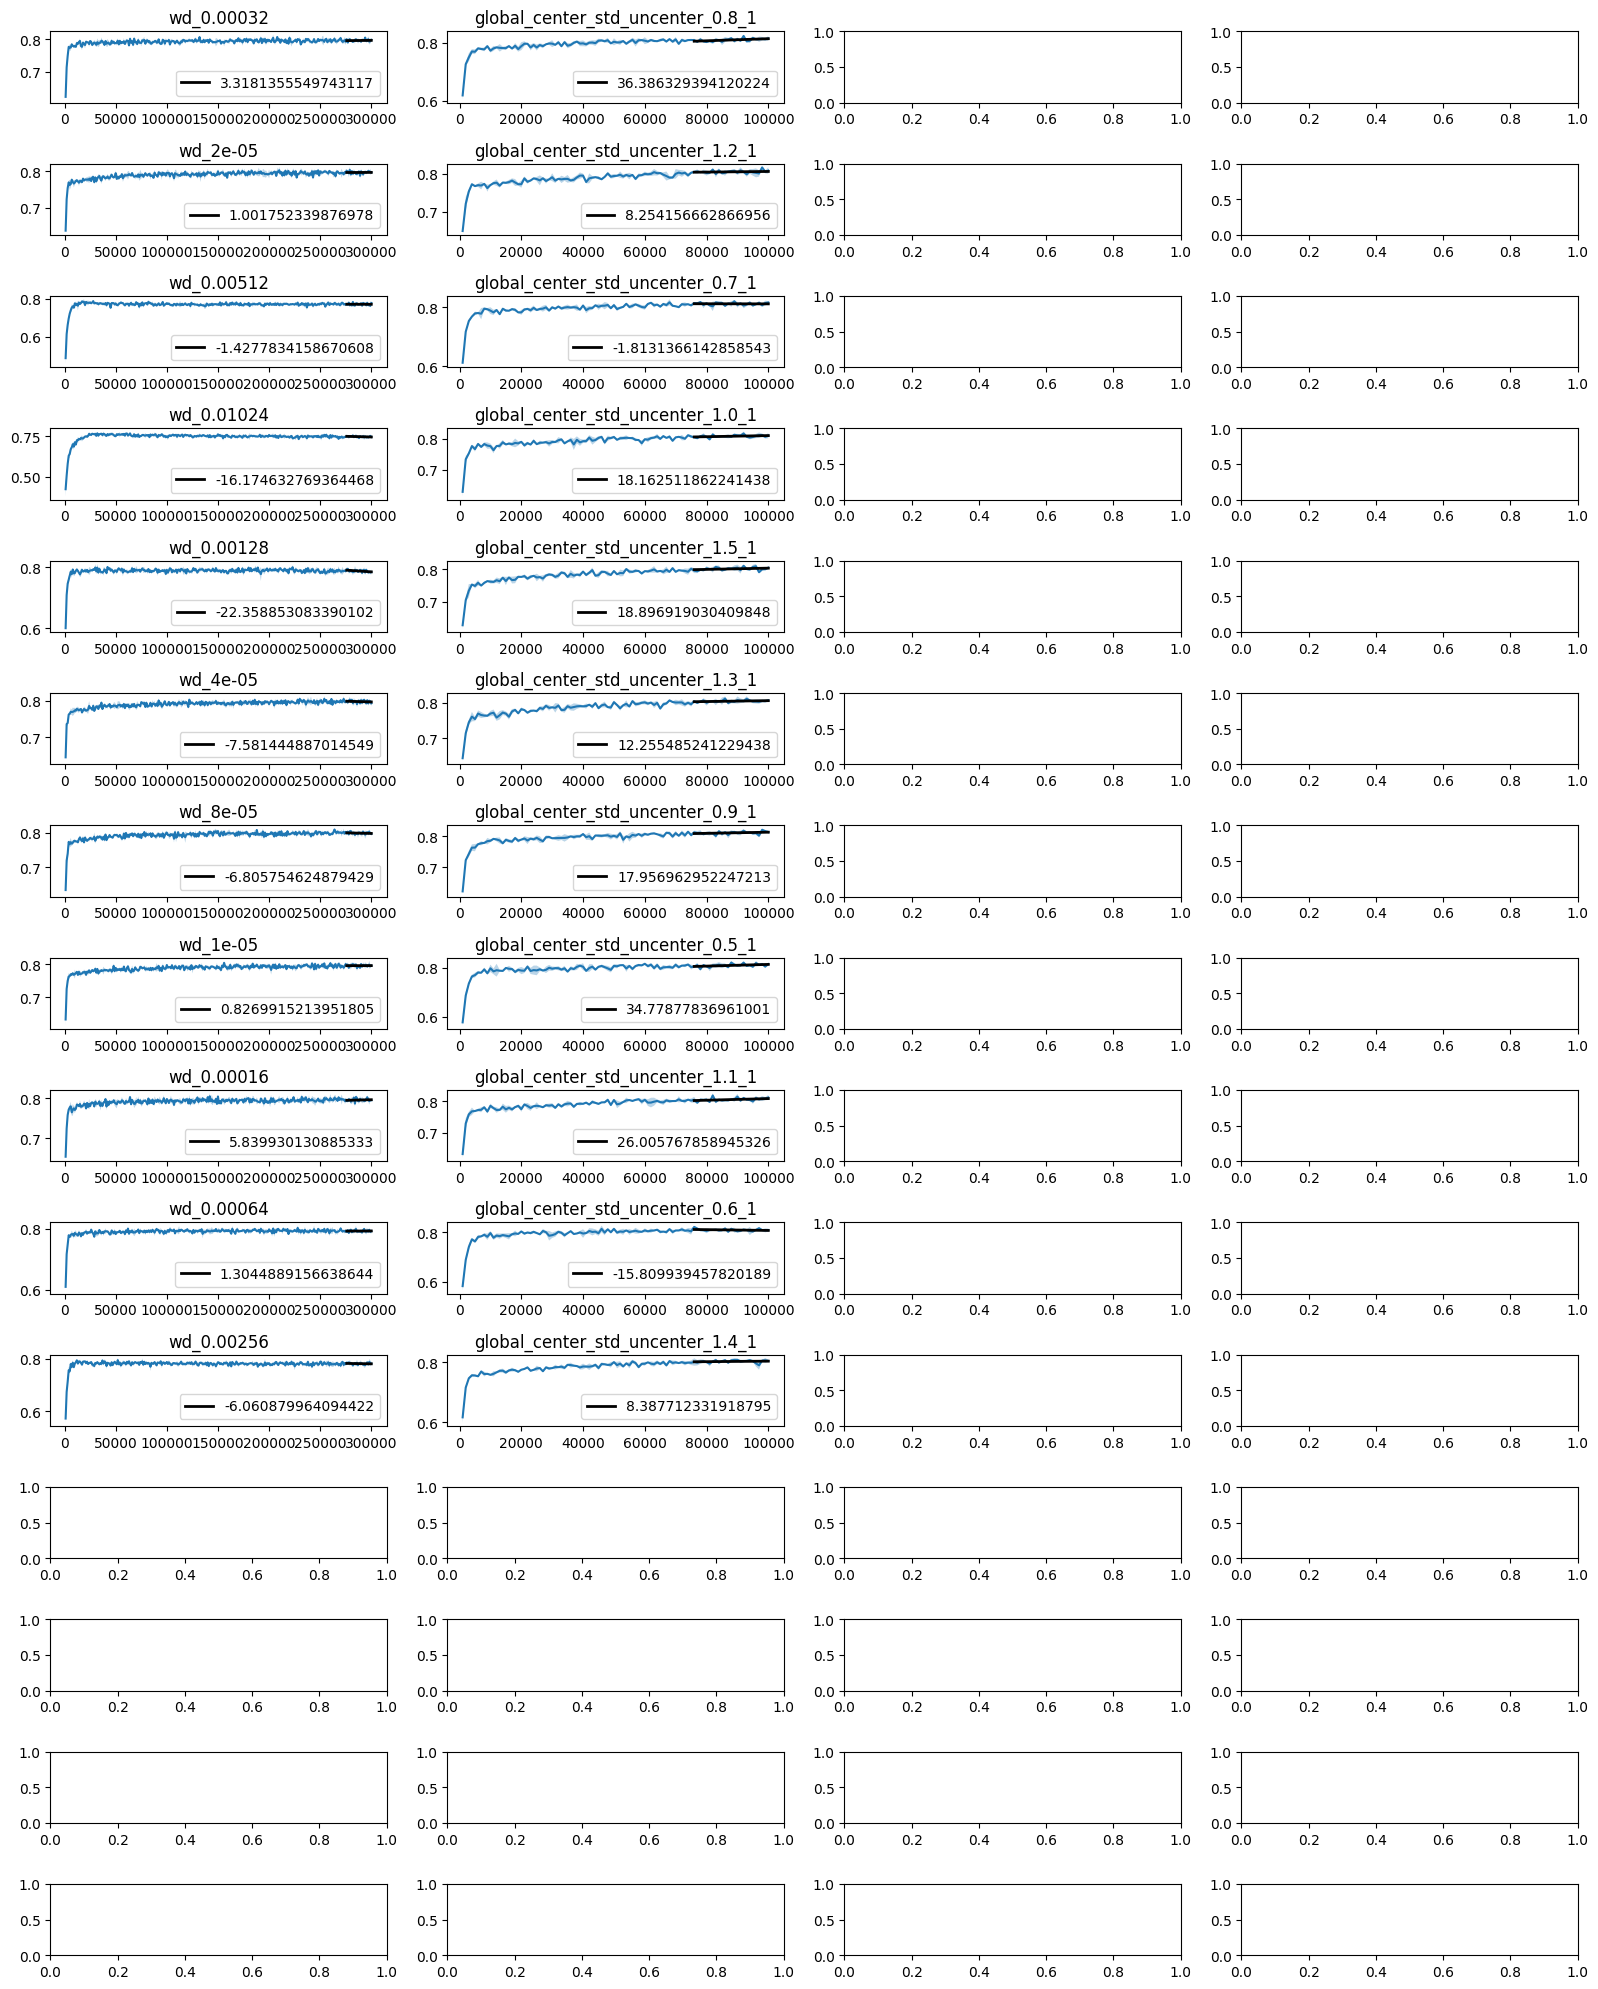

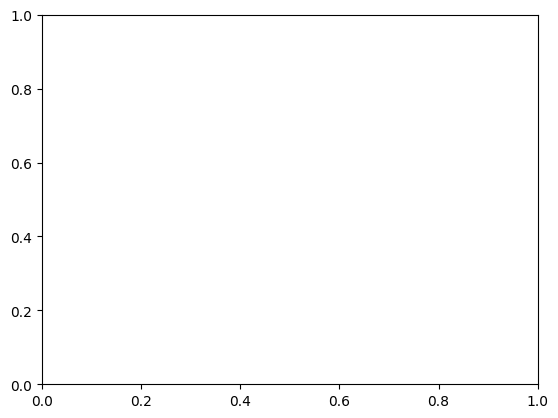

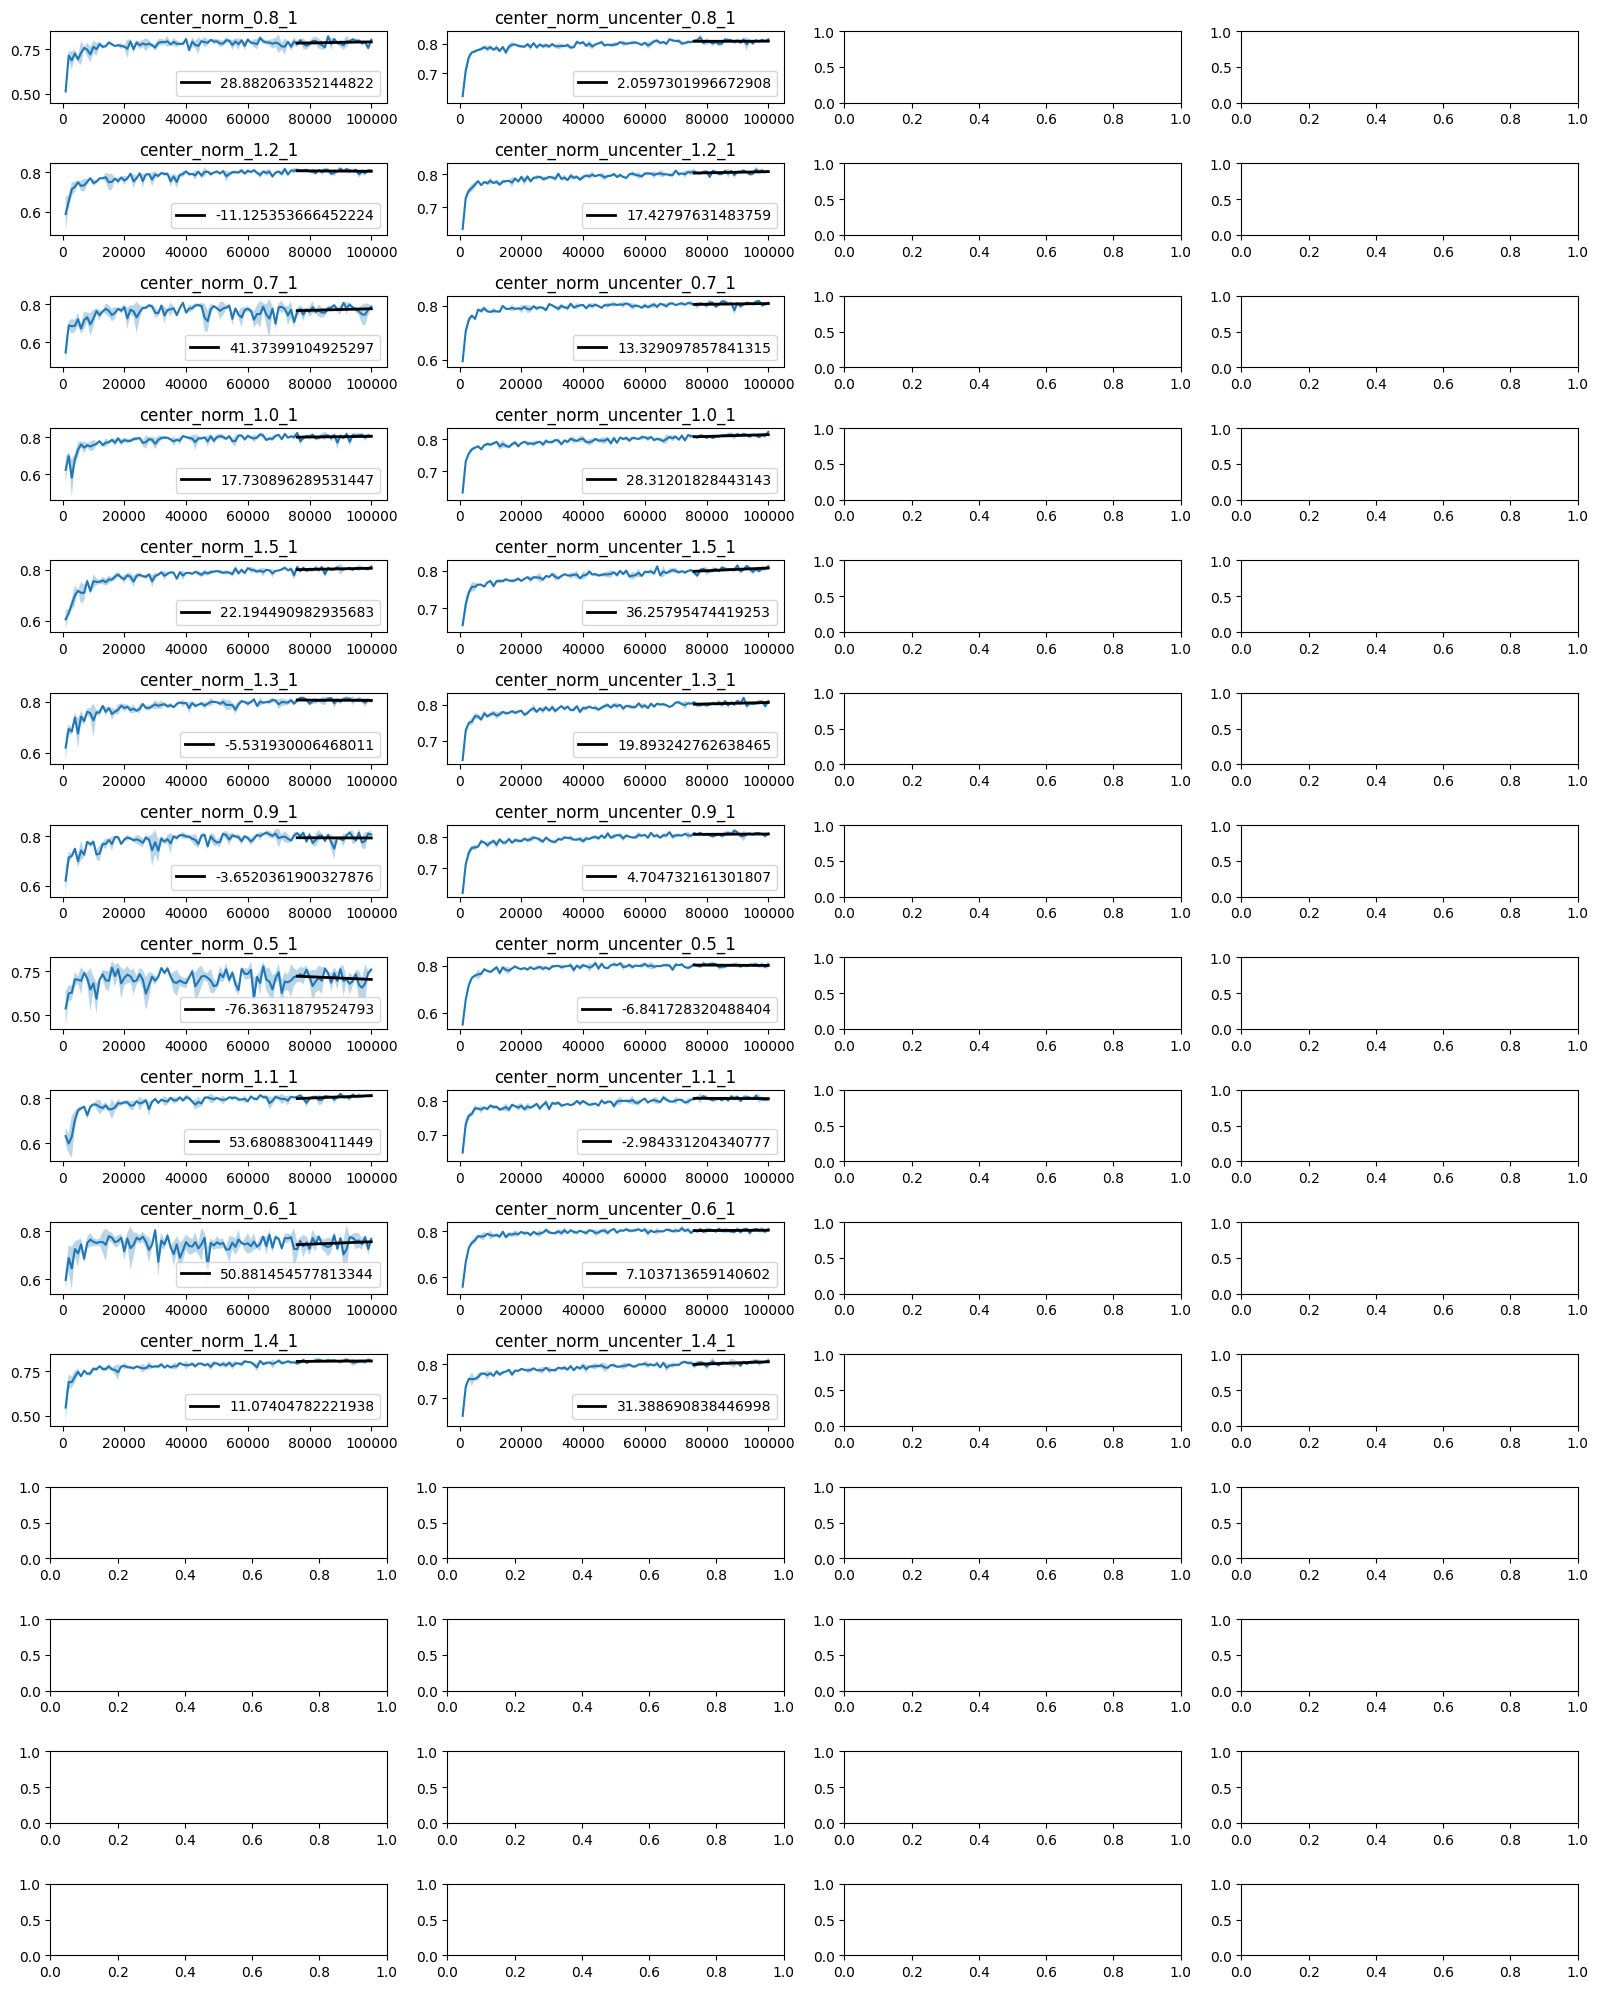

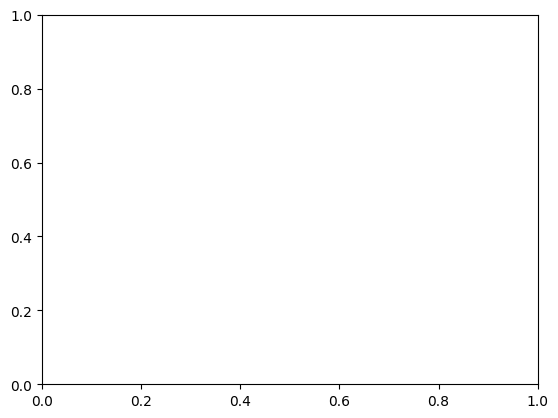

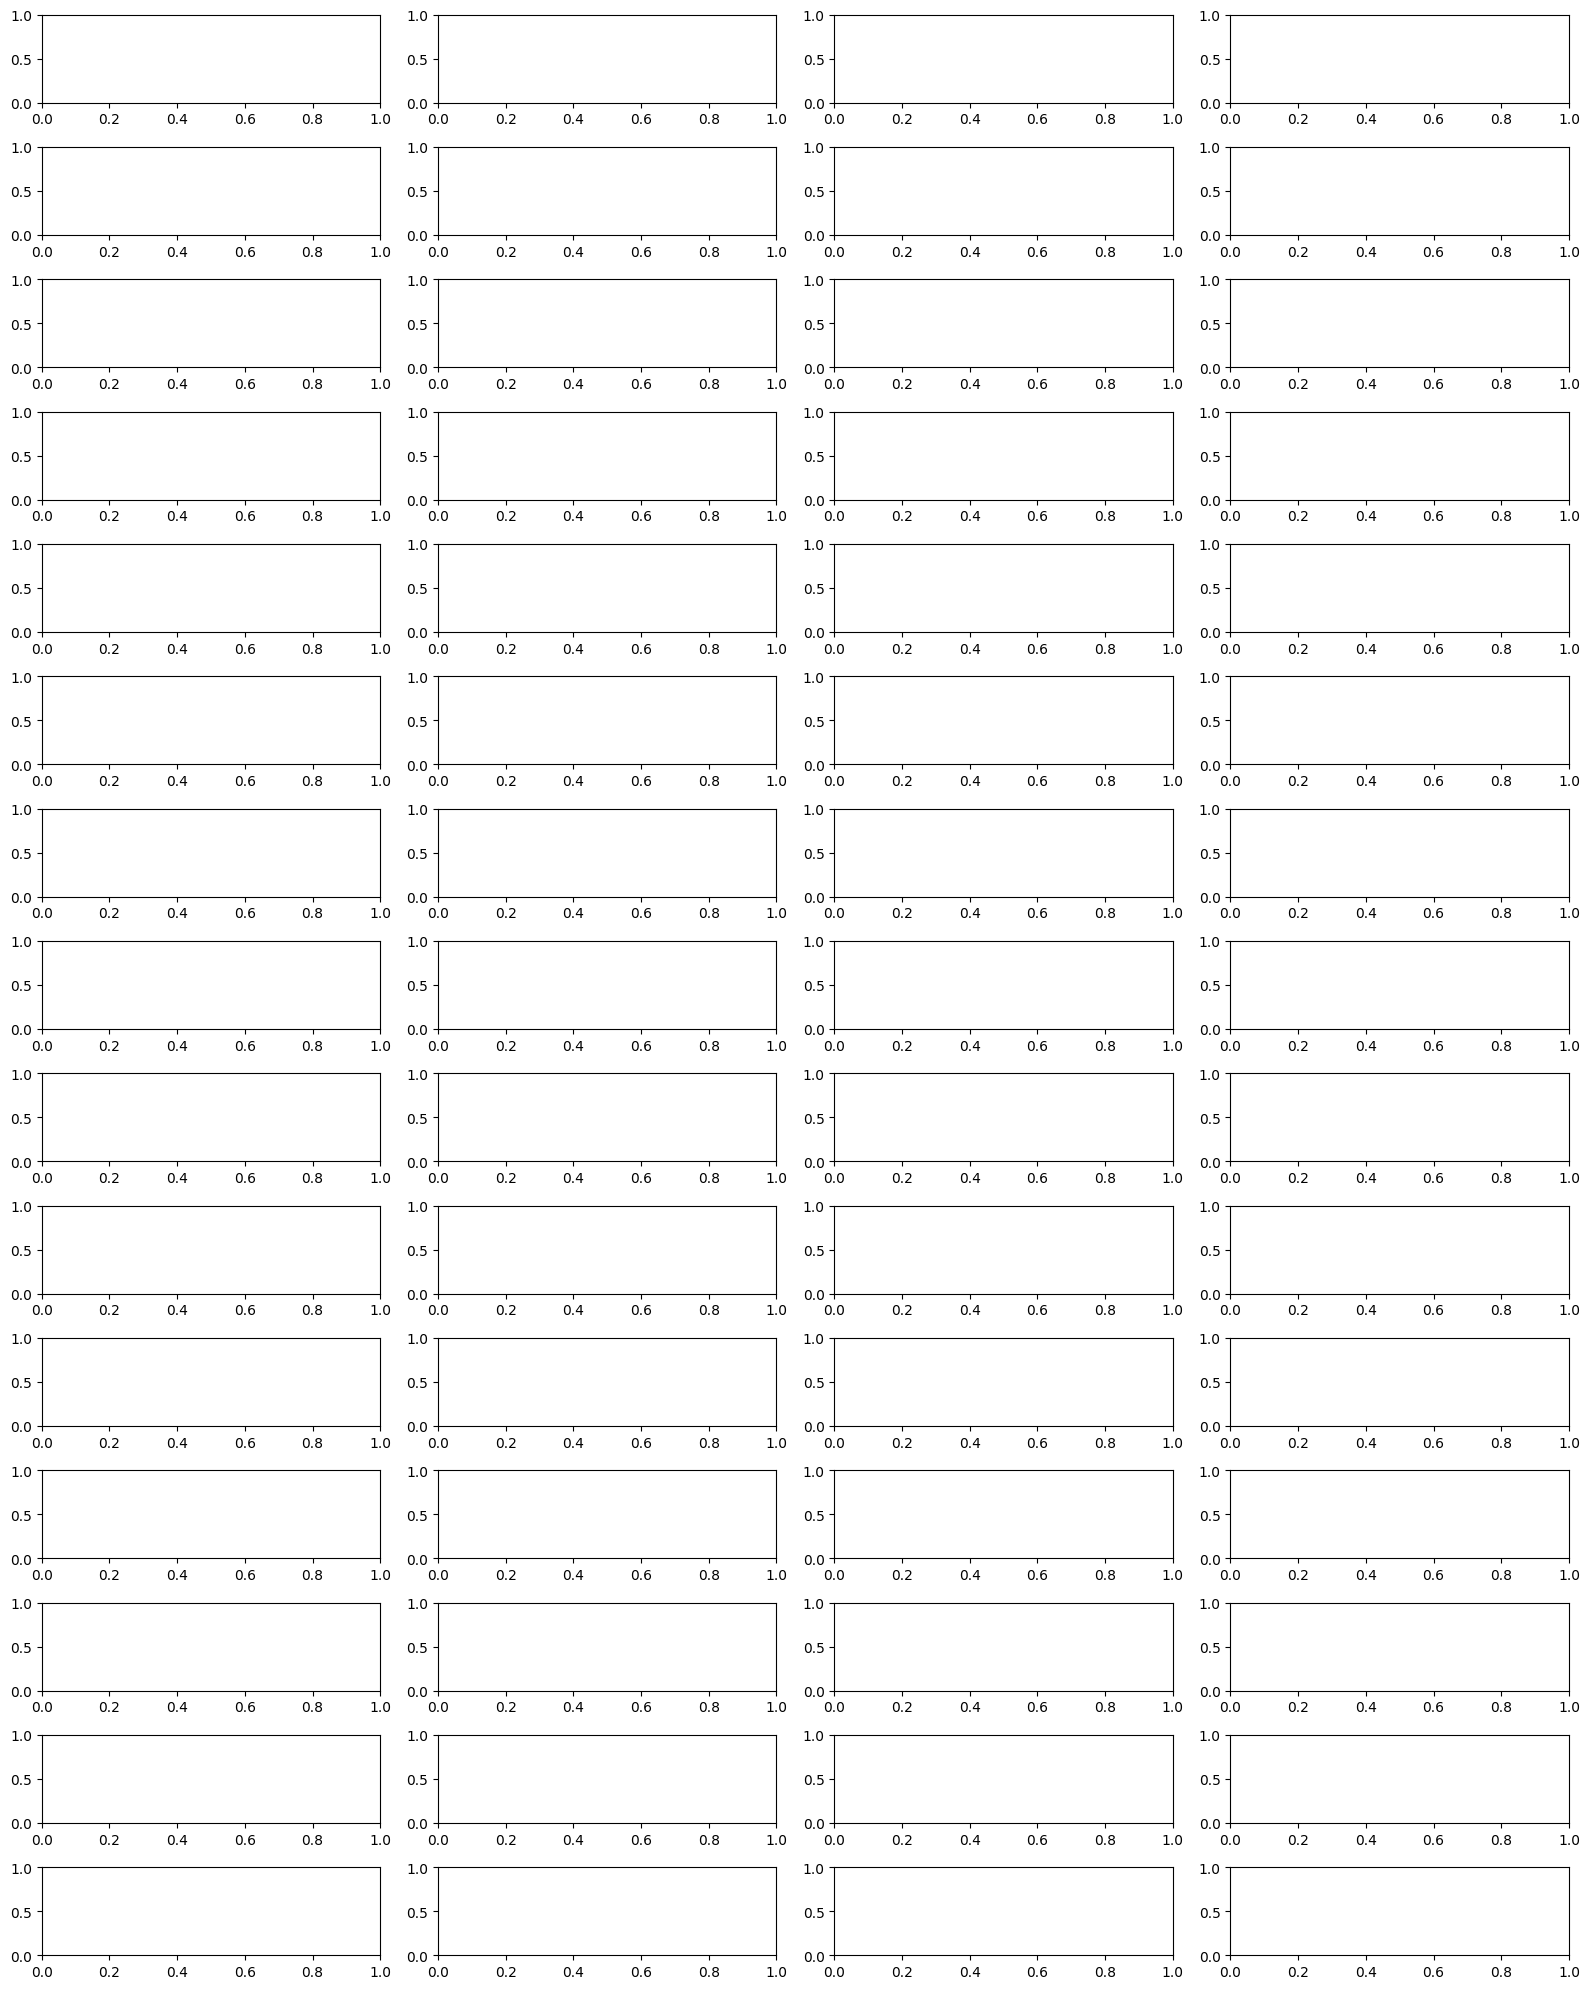

In [2]:
writer = write(name="a_wobn",path="../../run/adam_wobn",h=12,max_tasks=20)

fig,axs = plt.subplots(nrows=15,ncols=4)
cur_col = 0
setting = "adam_wobn"
for exp in os.listdir(f"../../data/{setting}"):

    if os.path.exists(os.path.join(f"../../data/{setting}",exp,"settings.json")):
        continue

    hyperparams = list(os.listdir(os.path.join(f"../../data/{setting}",exp)))

    for row,hyperparam in enumerate(hyperparams):
        if not os.path.exists(os.path.join(f"../../data/{setting}",exp,hyperparam,"test_stats")):
            axs[row][cur_col].set_title(exp + "_" + hyperparam)
            continue
        path = os.path.join(f"../../data/{setting}",exp,hyperparam)
        stats = get_stats(path,"test_stats")
        last_vals = np.mean(np.stack(list(stats["acc"].values())[-25:],axis=0),axis=-1)
        last_keys = np.asanyarray(list(stats["acc"].keys())[-25:])
        m,b = np.polyfit(last_keys, last_vals, 1)
        plot_step_stat(stats["acc"],axs[row][cur_col])
        axs[row][cur_col].set_title(exp + "_" + hyperparam)
        axs[row][cur_col].plot([last_keys[0],last_keys[-1]],[m*last_keys[0] + b,m*last_keys[-1]+ b],lw=2,color="black",label=str(m*1e8))
        axs[row][cur_col].legend()

        if m*1e8>4:
            import json
            with open(os.path.join(f"../../data/{setting}",exp,hyperparam,"settings.json"),"r") as f:
                js = json.load(f)
            curr_steps = js["num_steps"]
            save_states = js["save_args"]["save_states_every"]
            writer.write(f"python code/main.py {os.path.join("./data",setting,exp,hyperparam)}/ --overwrite-num-steps {curr_steps + 100000} --overwrite-save-state {curr_steps + 100000} --overwrite-save-grad {-1} \n")

    cur_col += 1
    if cur_col >= 2:
        fig.set_size_inches(16,20)
        fig.tight_layout()
        plt.show()
        plt.clf()
        plt.cla()
        fig,axs = plt.subplots(nrows=15,ncols=4)
        cur_col = 0

fig.set_size_inches(16,20)
fig.tight_layout()
plt.show()

